구글 Vision API
- https://cloud.google.com/vision/?hl=ko 



# <오늘 할 것:>

# 1. 얼굴 검출
- 1-1. `face_recognition`을 활용한 얼굴 검출
- 1-2. `dlib`을 활용한 얼굴 검출


# 2. 인물 판별
- 2-1. `face_recognition`을 활용한 이미지 인코딩
- 2-2. joy & lena 예제
    - `face_distance`
- 2-3. 디렉토리 단위로 유사도 계산하기
    - `compare_faces`

# 3. 성별/나이 인식


# 4. 감정
- 0131_emotion.ipynb 참조

(시간이 오래 걸려서 직접 실행은 못함)

# 5. 몽땅 다 합치기


# 1. 얼굴 검출

In [4]:
import math
import numpy as np
import cv2
import scipy.stats as sp
from PIL import ImageFont, ImageDraw, Image
import face_recognition
from imutils import face_utils
import imutils
import dlib
import matplotlib.pyplot as plt
import face_recognition
import os
from imutils import paths


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

## 1-1. `face_recognition`을 활용한 얼굴 검출

### `.face_locations(이미지)`
> 이미지를 인자로 넘겨주면 튜플 형식의 얼굴 좌표(상, 우, 하, 좌)들의 리스트를 리턴한다.

- model 인자를 지정할 수 있다.
    - 'hog': 디폴트 모델
    - 'cnn': 느리다 (strong classifier)

I found 1 face(s) in this image


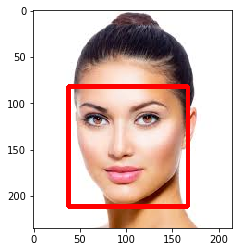

In [8]:
img = cv2.imread('face.jpg')

face_locations = face_recognition.face_locations(img)

print(f"I found {len(face_locations)} face(s) in this image")

for face_loc in face_locations:
    top, right, bottom, left = face_loc    #순서는 상, 우, 하, 좌
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 3)

imshow("", img)

In [9]:
print(face_locations)
print(type(face_locations))

[(82, 167, 211, 38)]
<class 'list'>


I found 5 face(s) in this image


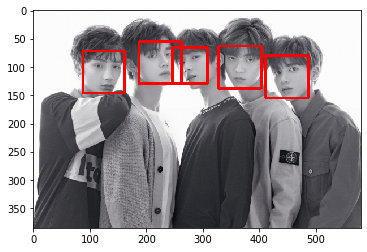

In [10]:
img = cv2.imread('face2.jpg')

face_locations = face_recognition.face_locations(img)

print(f"I found {len(face_locations)} face(s) in this image")

for face_loc in face_locations:
    top, right, bottom, left = face_loc
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 3)

imshow("", img)

인식한 얼굴 위치가 완전히 정교하지는 않다.

In [11]:
print(face_locations)
print(type(face_locations))

[(80, 486, 155, 411), (66, 308, 129, 246), (63, 403, 138, 328), (55, 262, 130, 187), (72, 162, 146, 88)]
<class 'list'>


I found 5 face(s) in this image


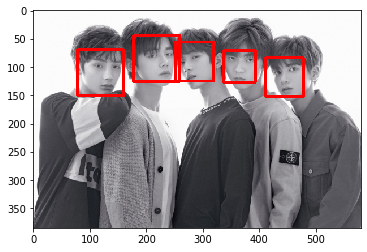

In [12]:
img = cv2.imread('face2.jpg')

face_locations = face_recognition.face_locations(img, model = 'cnn')

print(f"I found {len(face_locations)} face(s) in this image")

for face_loc in face_locations:
    top, right, bottom, left = face_loc
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 3)

imshow("", img)

cnn은 속도가 느리다. (13.9초)

I found 8 face(s) in this image


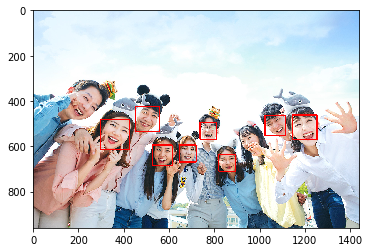

In [13]:
img = cv2.imread('people.jpg')

face_locations = face_recognition.face_locations(img)

print(f"I found {len(face_locations)} face(s) in this image")

for face_loc in face_locations:
    top, right, bottom, left = face_loc
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 3)

imshow("", img)

2개 얼굴을 놓쳤으나, opencv의 haar-like보다는 그래도 낫다.

I found 10 face(s) in this image


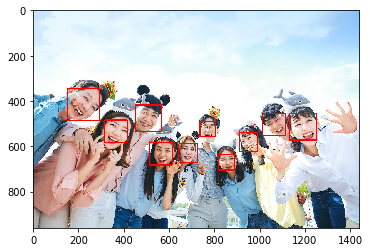

In [14]:
img = cv2.imread('people.jpg')

face_locations = face_recognition.face_locations(img, model = 'cnn')

print(f"I found {len(face_locations)} face(s) in this image")

for face_loc in face_locations:
    top, right, bottom, left = face_loc
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 3)

imshow("", img)

cnn 시간이 진짜 오래 걸린다. (1분 23초) 대신 얼굴을 모두 다 찾는다.

## 1-2. `dlib`을 활용한 얼굴 검출

### `.get_frontal_face_detector()`
> 얼굴 검출기를 생성하는 메소드

### `디텍터(이미지(그레이), 0)`
>  dlib.rectangle을 원소들로 갖는 dlib.rectangles object를 리턴한다.
(list처럼 취급 가능; for, len, indexing)

- dlib.rectangle 데이터타입은 [(좌, 상) (우, 하)]처럼 생겼다.
    - `.left()`, `.right()`, `.top()`, `.bottom()` 메소드로 각각의 좌표에 접근할 수 있다.

### `.shape_predictor(프리딕터 파일)`
> 프리딕터를 생성하는 메소드

- `predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

### `프리딕터(이미지(그레이), dlib.rectangle)`
> 특징점 좌표를 원소로 갖는 dlib.full_object_detection object를 리턴한다.

- `shape = predictor(img, rect)`
- 보통 np array로 형변환을 해서 사용한다.
    - 형변환을 위해서는 `imutils` 라이브러리의 `face_utils`의 `shape_to_np` 메소드를 활용한다.
        - `shape = face_utils.shape_to_np(shape)`
- 특징점은 고유 인덱스를 가지므로, 인덱스 번호로 얼굴의 특정 피처의 위치를 나타내는 특징점에 접근할 수 있다.
    - e.g. 36번 인덱스는 왼쪽 눈꼬리

<img src=facial_landmarks.jpg>

*주의: 이 이미지의 번호는 1부터, `predictor`로 locate한 특징점들의 인덱스는 0부터 시작한다.

In [67]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

frame = cv2.imread("face.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)  
print("Number of faces detected: {}".format(len(rects)))
for r in rects :
    print(r)

Number of faces detected: 1
[(37, 79) (162, 203)]


In [68]:
print(rects)
print(type(rects))
for r in rects:
    print(type(r))

<class 'dlib.dlib.rectangles'>
<class 'dlib.dlib.rectangle'>


Detection 0: Left: 37 Top: 79 Right: 162 Bottom: 203
<class 'dlib.dlib.full_object_detection'>
[[ 46 118]
 [ 47 131]
 [ 50 144]
 [ 54 158]
 [ 59 171]
 [ 66 184]
 [ 74 197]
 [ 84 207]
 [ 97 209]
 [112 207]
 [127 199]
 [140 190]
 [151 178]
 [157 164]
 [160 148]
 [162 131]
 [163 115]
 [ 50 103]
 [ 57  99]
 [ 65 101]
 [ 72 104]
 [ 80 107]
 [104 106]
 [114 101]
 [124  98]
 [134  98]
 [144 101]
 [ 93 120]
 [ 92 130]
 [ 92 141]
 [ 91 152]
 [ 85 158]
 [ 89 160]
 [ 93 161]
 [ 98 159]
 [103 157]
 [ 59 119]
 [ 65 115]
 [ 74 115]
 [ 80 122]
 [ 72 124]
 [ 64 123]
 [111 121]
 [117 115]
 [126 114]
 [132 118]
 [127 122]
 [118 123]
 [ 76 172]
 [ 83 169]
 [ 90 167]
 [ 95 169]
 [100 167]
 [109 169]
 [118 172]
 [110 181]
 [101 186]
 [ 95 186]
 [ 89 185]
 [ 82 180]
 [ 80 174]
 [ 90 174]
 [ 95 175]
 [101 175]
 [115 173]
 [101 175]
 [ 95 176]
 [ 89 175]]
<class 'numpy.ndarray'>
68


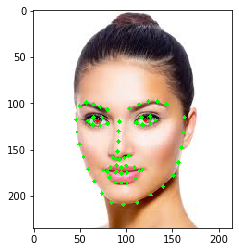

In [70]:
#양쪽 눈 특징점의 인덱스 번호가 저장된 리스트 변수
left = list(range(36, 42))
right = list(range(42, 48))

for k, d in enumerate(rects):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        shape = predictor(gray, d)
        print(shape)
        print(type(shape))
        shape = face_utils.shape_to_np(shape)
        print(shape)
        print(type(shape))
        print(len(shape))
        for (x, y) in shape:
            cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)
        left_center = shape[left].mean(axis = 0).astype(int)
        right_center = shape[right].mean(axis = 0).astype(int)
        cv2.circle(frame, (left_center[0], left_center[1]), 2, (0, 0, 255), -1)
        cv2.circle(frame, (right_center[0], right_center[1]), 2, (0, 0, 255), -1)

imshow("", frame)

# 2. 인물 판별

> 따로 학습을 시키는 것이 아니라, 두 얼굴의 인코딩 값 사이의 거리를 기반으로 유사도를 계산하여서 일치 여부를 판별하는 방식이다.

## 2-1. `face_recognition`을 활용한 이미지 인코딩

### `.load_image_file('이미지 파일')`
> `face_recognition` 라이브러리의 이미지 읽어오는 메소드

- ndarray 타입을 리턴함

### `.face_encodings(이미지)`
> `face_recognition` 라이브러리의 이미지 인코딩 메소드

- ndarray 타입의 인코딩 결과를 원소로 갖는 리스트를 리턴함
- 이미지 크기에 상관없이 128차원으로 인코딩함

In [74]:
img = face_recognition.load_image_file('face.jpg')
print(type(img))
print(img)
face_encoding = face_recognition.face_encodings(img)

print(type(face_encoding))
print(len(face_encoding))
print(type(face_encoding[0]))
#print(face_encoding)
print(face_encoding[0].shape)    #0번째 얼굴 shape

<class 'numpy.ndarray'>
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
<class 'list'>
1
<class 'numpy.ndarray'>
(128,)


## 2-2. joy & lena 예제

### `face_distance`
> 테스트이미지와 원본이미지들 간의 거리를 계산해주는 메소드
- `face_recognition.face_distance(known_face_encodings, test_face_encoding)`
    - 인자를 두 개 받는다.
        - known_face_encodings: 원본 이미지들의 인코딩 값들을 원소로 갖는 리스트
        - test_face_encoding: 테스트할 이미지의 인코딩 값
        - (인코딩 값은 `face_recognition.face_encodings`로 계산할 수 있다.)
        
- 보통 거리가 0.6 이하인 원본이미지 중 테스트이미지와의 최소 거리를 갖는 이미지를 동일 인물로 취급한다.

joy.jpeg


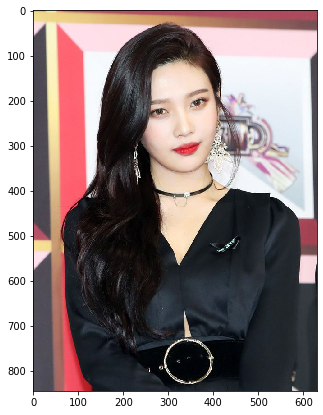

lena.jpg


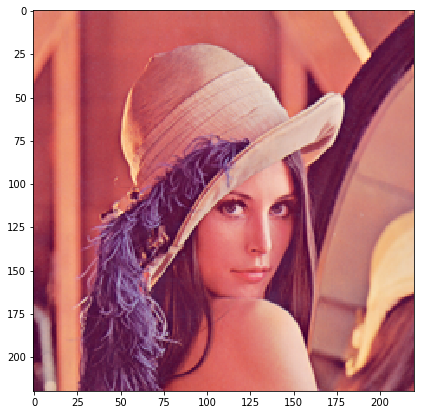

In [83]:
files = os.listdir("known")

known_face_encodings = []
known_face_names = []

for filename in files:
    print(filename)
    name, ext = os.path.splitext(filename)    #os.path.splittext: '.' 기준으로 파일명을 나눠주는 메소드
    if ext == '.jpg' or ext == '.jpeg':
        known_face_names.append(name)
        pathname = os.path.join("known", filename)
        img = face_recognition.load_image_file(pathname)
        plt.figure(figsize = (7, 7))
        imshow("", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        face_encoding = face_recognition.face_encodings(img)[0]
        known_face_encodings.append(face_encoding) 
        
        

In [93]:
joy = cv2.imread('known/joy.jpeg')
lena = cv2.imread('known/lena.jpg')

In [99]:
test = face_recognition.load_image_file('known/joy2.jpeg')   #joy2.jpeg는 joy.jpeg를 좌우반전한 이미지

face_locations = face_recognition.face_locations(test)
face_encodings = face_recognition.face_encodings(test, face_locations)

face_names = []

for face_encoding in face_encodings:
    distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    print(distances)
    min_value = min(distances)
    
    name = "Unknown"
    
    if min_value < 0.6:
        index = np.argmin(distances)
        name = known_face_names[index]
    print(f"{face_encodings.index(face_encoding)} 번째 얼굴은 {name}이다.")

[0.15396975 0.87335579]
0 번째 얼굴은 joy이다.


In [89]:
#아예 다른 joy 이미지를 넣어본다
test = face_recognition.load_image_file('known/joy3.jpg')

face_locations = face_recognition.face_locations(test)
face_encodings = face_recognition.face_encodings(test, face_locations)

face_names = []

for face_encoding in face_encodings:
    distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    print(distances)
    min_value = min(distances)
    
    name = "Unknown"
    
    if min_value < 0.6:
        index = np.argmin(distances)
        name = known_face_names[index]
    print(f"{face_encodings.index(face_encoding)} 번째 얼굴은 {name}이다.")

[0.28525487 0.91769875]
0 번째 얼굴은 joy이다.


In [90]:
#아예 다른 사람을 넣어본다.
test = face_recognition.load_image_file('known/rose.jpg')

face_locations = face_recognition.face_locations(test)
face_encodings = face_recognition.face_encodings(test, face_locations)

face_names = []

for face_encoding in face_encodings:
    distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    print(distances)
    min_value = min(distances)
    
    name = "Unknown"
    
    if min_value < 0.6:
        index = np.argmin(distances)
        name = known_face_names[index]
    print(f"{face_encodings.index(face_encoding)} 번째 얼굴은 {name}이다.")

[0.42892952 0.79731804]
0 번째 얼굴은 joy이다.


In [91]:
#서양인으로 넣어본다.
test = face_recognition.load_image_file('known/wf.jpg')

face_locations = face_recognition.face_locations(test)
face_encodings = face_recognition.face_encodings(test, face_locations)

face_names = []

for face_encoding in face_encodings:
    distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    print(distances)
    min_value = min(distances)
    
    name = "Unknown"
    
    if min_value < 0.6:
        index = np.argmin(distances)
        name = known_face_names[index]
    print(f"{face_encodings.index(face_encoding)} 번째 얼굴은 {name}이다.")

[0.76816007 0.72998227]
0 번째 얼굴은 Unknown이다.


joy와 lena 모두 거리가 멀어서(0.6 이상) Unknown이 출력되었다.

## 2-3. 디렉토리 단위로 유사도 계산하기

### `paths.list_images('디렉토리명')`
> 디렉토리명을 인자로 전달받아 해당 디렉토리의 모든 이미지 파일 경로를 읽어와 리스트로 리턴한다.

- `imutils` 라이브러리의 `paths` 모듈의 메소드임

### `compare_faces(인코딩값 전체, 특정 이미지 인코딩값, tolerance)`
> 특정 이미지와 전체 이미지 사이의 매치 여부를 인코딩 값 사이의 distance를 기반으로 계산하여 boolean값(True/False)들의 리스트로 리턴한다.

- tolerance는 인코딩값 사이의 distance threshold 이다.
    - 따라서 낮은 값을 줄수록 엄격한 기준으로 유사도를 판단한다.
        - e.g. tolerance = 0.4로 지정할 시, 거리가 0.4 미만일 때만 True로 판단
    - 디폴트는 0.6으로 지정되어 있다.

In [141]:
imagePaths = list(paths.list_images("known"))
 
knownEncodings = []
knownNames = []

for (i, imagePath) in enumerate(imagePaths):    
    name = imagePath.split(os.path.sep)[-2]    #os.path.sep: os별로 상이한 구분자를 리턴한다.
    # 끝에서 두번째니까, 이미지파일의 상위 디렉토리가 name 변수에 저장된다.
    print(f"{name}   -   {imagePath}") 
    image = cv2.imread(imagePath)
    boxes = face_recognition.face_locations(image)    #이미지에서 얼굴 위치를 (상, 우, 하, 좌) 순서로 나타낸 튜플의 리스트
#     print(boxes)
#     print(type(boxes))
    encodings = face_recognition.face_encodings(image, boxes)   #각 이미지를 128차원으로 인코딩한 ndarray의 리스트
#     print(encodings)
#     print(type(encodings))

    for encoding in encodings:        
        knownEncodings.append(encoding)
        knownNames.append(name)
        
import pickle
data = {"encodings": knownEncodings, "names": knownNames}
f = open("known.bin", "wb")      #'wb': write binary
f.write(pickle.dumps(data))
f.close()

known   -   known\wf.jpg
joy   -   known\joy\joy.jpeg
joy   -   known\joy\joy2.jpeg
joy   -   known\joy\joy3.jpg
joy   -   known\joy\joy4.jpg
joy   -   known\joy\joy5.jpeg
lena   -   known\lena\lena.jpg
lena   -   known\lena\lena2.jpg
lena   -   known\lena\lena3.jpg
lena   -   known\lena\lena4.jpg
lena   -   known\lena\lena5.jpg
rose   -   known\rose\rose.jpg
rose   -   known\rose\rose2.jpg
rose   -   known\rose\rose3.jpg
rose   -   known\rose\rose4.jpg
rose   -   known\rose\rose5.jpg


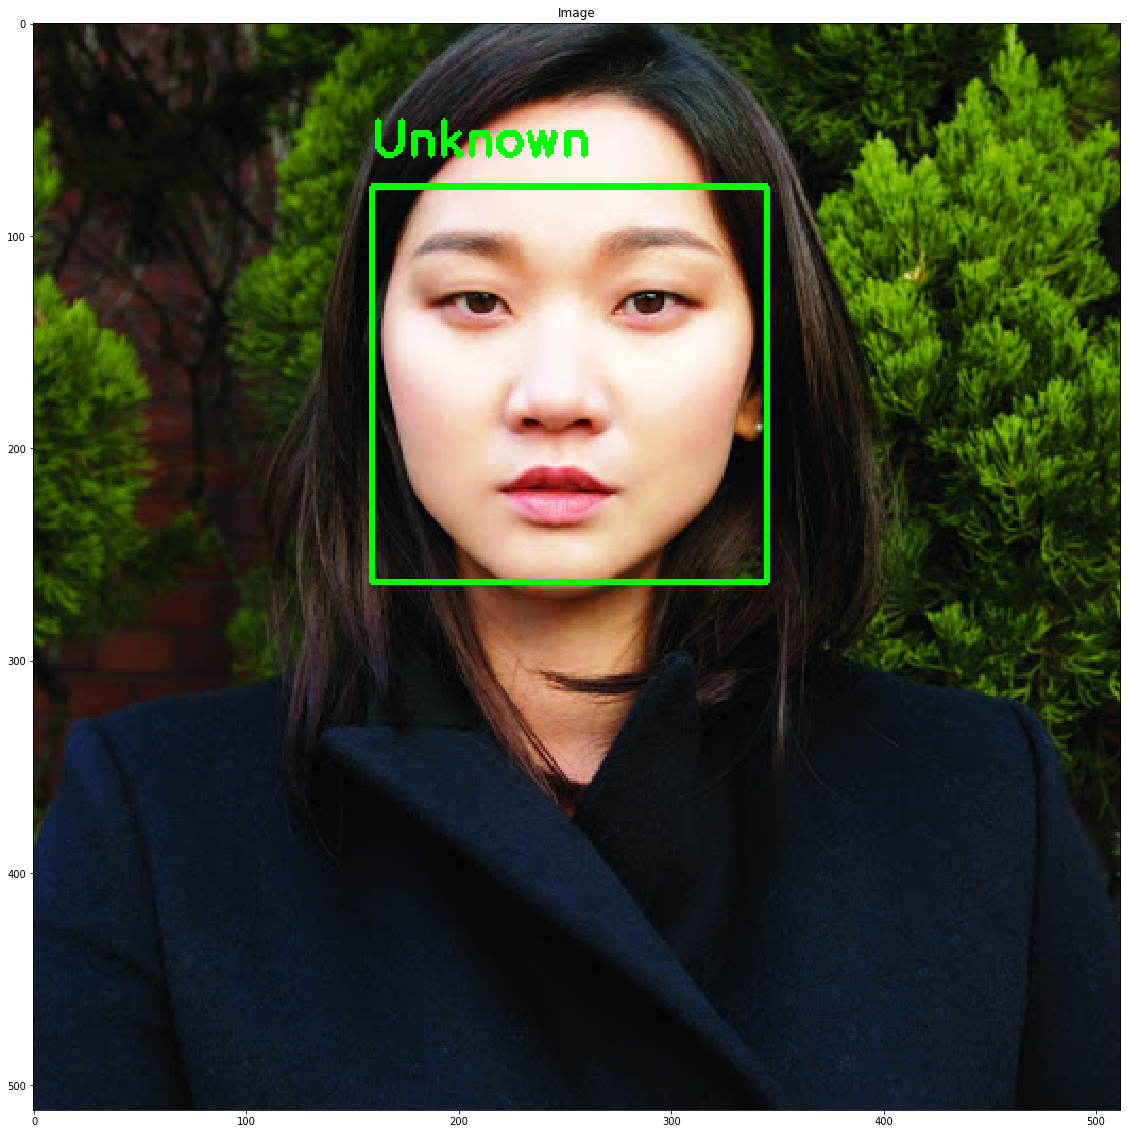

In [164]:
data = pickle.loads(open("known.bin", "rb").read())     #'rb': read binary
 
image = cv2.imread("test10.jpg")

boxes = face_recognition.face_locations(image)
encodings = face_recognition.face_encodings(image, boxes)
 
names = []
for encoding in encodings:
    matches = face_recognition.compare_faces(data["encodings"], encoding, tolerance = 0.4)
    name = "Unknown"
    if True in matches:
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {} 
        for i in matchedIdxs:
            name = data["names"][i]
            counts[name] = counts.get(name, 0) + 1 
        name = max(counts, key=counts.get)
    names.append(name)                             
for ((top, right, bottom, left), name) in zip(boxes, names):
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    y = top - 15 if top - 15 > 15 else top + 15
    cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,  0.75, (0, 255, 0), 2)

plt.figure(figsize = (20, 20))
imshow("Image", image)

성능이 괜찮다.

### `.get(키, 디폴트값)`
> dictionary 데이터타입의 built-in 메소드

> 키와 디폴트값을 인자로 전달하면, 키가 존재할 시 키에 해당하는 밸류를, 키가 존재하지 않을 시 디폴트값을 리턴한다.

In [110]:
a = {}
print(a.get('hello', 0))   #'hello' 키가 존재하지 않을 때
a['hello'] = 1
print(a.get('hello', 0))          #'hello' 키가 존재할 때

0
1


### DNN을 붙여주면 오류를 거를 수 있다.
- output 레이어에'softmax'를 붙여주면 **확률**로 리턴하기 때문에 threshold를 지정해서 특정값 미만이면 'unknown' 등으로 분류하도록 할 수 있다.

#### 딥러닝의 학습데이터로 바꿔주기
- 독립변수: `np.array()`
    - 인코딩값을 샘플 수 x 디멘션 어레이로 바꾸기
- 종속변수(레이블): `pd.factorize()`
    - 레이블을 숫자로 변환하기
    - 두 개 원소를 갖는 튜플을 리턴한다.
        - 클래스를 정수화(int64)한 array
        - 원래 클래스를 그대로 가져온 array

In [163]:
#인코딩값을 넘파이 어레이로 바꿔주기 --> np.array() 메소드를 활용해서.
feature = np.array(data['encodings'])
print(feature.shape)    # 샘플 수 x 디멘션(128차원)

#인물명을 딥러닝의 레이블로 바꿔주기 --> pd.factorize() 메소드를 활용해서
c = pd.factorize(data['names'])
print(c)
label = c[0]
print(label)

(16, 128)
(array([0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3], dtype=int64), array(['known', 'joy', 'lena', 'rose'], dtype=object))
[0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [168]:
type(c)

tuple

# 3. 성별/나이 인식

In [2]:
import cv2 as cv2
import math
import time

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes


faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

padding = 25

frame = cv2.imread("test.jpg")
frameFace, bboxes = getFaceBox(faceNet, frame)
for bbox in bboxes:
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)        
        cv2.imwrite("age-gender-out-{}.jpg".format(input()),frameFace)

Gender : Male, conf = 0.950
Age Output : [[1.5615560e-05 3.3251735e-04 3.1123275e-01 5.0079143e-01 1.8564637e-01
  1.6352300e-03 2.4504005e-04 1.0102564e-04]]
Age : (15-20), conf = 0.501
7


padding을 바꿔주면 결과값이 조금씩 달라진다.

# 5. 몽땅 다 합치기

순서를 정리해보자

1. 얼굴 검출
    - `dlib`
        - `face_recognition.face_locations`를 쓸 수도 있지만, 어차피 특징점도 검출해야하기 때문에 둘 다 같이 할 수 있는 `dlib.get_frontal_face_detector`로 디텍터를 생성해서 쓸 거다.

2. 인물 판별
    - `face_recognition.face_encodings`


3. shape 따기(68개 특징점 검출하기)
    - `dlib.

4. 성별/나이 인식하기

5. 감정 인식하기(표정 인식하기)

In [3]:
# to be continued.........

In [ ]:
import math
import numpy as np
import cv2
import scipy.stats as sp
from PIL import ImageFont, ImageDraw, Image
import face_recognition
from imutils import face_utils
import imutils
import dlib
import matplotlib.pyplot as plt
import face_recognition
import os
from imutils import paths


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

    
# 1. 얼굴 검출
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

frame = cv2.imread("face.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    #그레이 변환
rects = detector(gray, 0)  
    
# 2. 인물 판별


# 3. 68 개 특징점 추출

for k, d in enumerate(rects):
    shape = predictor(gray, d)
    shape = face_utils.shape_to_np(shape)
    for (x, y) in shape:
        cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)
        
        
imshow("", frame)